# Multiclass Classification with MLP (TensorFlow/Keras)
### Breast Cancer Wisconsin Dataset

**Цель:** Построить многослойный перцептрон (MLP) для задачи классификации медицинских данных.  
**В процессе:**  
- Проведена разведка данных (EDA)
- Нормализация признаков
- Построение и обучение MLP
- Анализ результатов (метрики, графики)

**Фреймворк:** TensorFlow / Keras  
**Датасет:** Breast Cancer Wisconsin (sklearn.datasets)

---

_Этот ноутбук выполнен в рамках магистерской работы по курсу "Искусственный интеллект и глубокое обучение"._


**Примечание:** Этот ноутбук был оптимизирован и выполнен локально на архитектуре Apple Silicon (M1, macOS). Некоторые части кода (например, использование tensorflow-metal, специфичная многопоточность или ускорения) могут потребовать адаптации для корректного запуска в среде Kaggle или Google Colab

In [1]:
# !pip install -q scikit-learn pandas matplotlib tensorflow seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import sklearn
import tensorflow as tf

print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("TensorFlow version:", tf.__version__)


NumPy version: 1.24.4
Pandas version: 2.2.3
Matplotlib version: 3.9.4
Seaborn version: 0.13.2
Scikit-learn version: 1.6.1
TensorFlow version: 2.9.2


## Кластеризация + визуализация

**Подготовка и загрузка изображений для анализа**

- Изображения собраны из папки `images/` (всего: 1584 файла).
- Каждый файл масштабируется до размера **64×64 пикселя** и преобразуется в трехканальный массив (RGB).
- Все значения нормированы в диапазоне [0, 1] для подачи в нейронную сеть.
- Использованы стандартные средства загрузки и препроцессинга TensorFlow/Keras.

In [7]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

# Настройки
IMG_DIR = 'images'
IMG_SIZE = (64, 64)

# Загрузка изображений
X = []
filenames = []
for file in tqdm(os.listdir(IMG_DIR)):
    if file.endswith('.jpg') or file.endswith('.jpeg') or file.endswith('.png'):
        img_path = os.path.join(IMG_DIR, file)
        img = image.load_img(img_path, target_size=IMG_SIZE)
        img_array = image.img_to_array(img) / 255.0
        X.append(img_array)
        filenames.append(file)

X = np.array(X)
print("Форма массива X:", X.shape)


100%|██████████| 1584/1584 [00:01<00:00, 1130.16it/s]


Форма массива X: (1584, 64, 64, 3)


**Унифицировали данные для подачи в модель и дальнейшей обработки.**

- Загружено 1584 изображения из одной папки.

- Каждое изображение приведено к размеру 64×64 с 3 цветными каналами (RGB).

- Полученная форма массива: (1584, 64, 64, 3).

- Все значения нормированы в диапазон [0, 1].

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Векторизация изображений
X_flat = X.reshape(X.shape[0], -1)  # (1584, 12288)

# Стандартизация признаков (важно! перед PCA/кластеризацией)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# PCA — уменьшаем размерность до 50
pca = PCA(n_components=50, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Форма после PCA:", X_pca.shape)


Форма после PCA: (1584, 50)


**Сохранили максимум информации (дисперсии) и при этом сократил вычислительную нагрузку при кластеризации.**

- Изображения были "развернуты" в векторы признаков формы (1584, 12288) — т.е. каждый пиксель стал отдельной переменной.

- Перед кластеризацией признаки были стандартизированы с помощью StandardScaler.



In [9]:
# Кластеризация (тут можно поиграть с n_clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

print("Пример кластеров:", clusters[:10])


Пример кластеров: [0 2 2 2 2 0 0 0 0 0]


**Алгоритм KMeans разделил изображения на 3 кластера.**

- Кластеры пронумерованы: 0, 1, 2. 

- Пример первых 10 меток: [0 2 2 2 2 0 0 0 0 0]

Это означает, что алгоритм самостоятельно нашел 3 группы сходных изображений (по цвету, форме, структуре и т.д.).

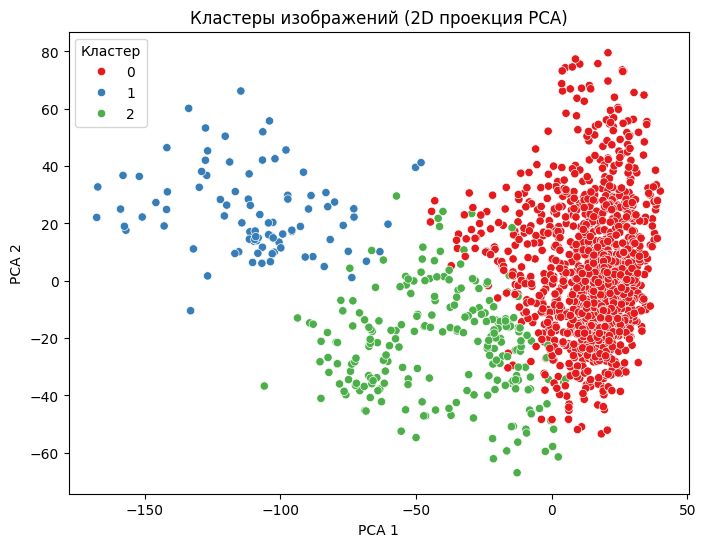

In [10]:
# Дополнительное PCA до 2D для визуализации
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=clusters, palette='Set1')
plt.title("Кластеры изображений (2D проекция PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Кластер")
plt.show()

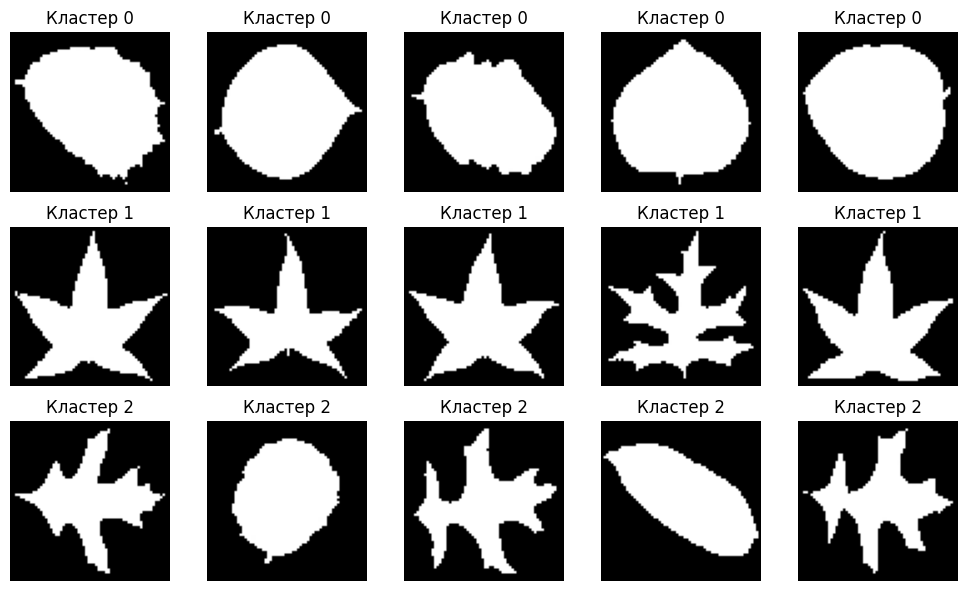

In [11]:
import matplotlib.pyplot as plt

# Функция для вывода примеров по кластерам
def show_cluster_examples(X_images, cluster_labels, n_per_cluster=5):
    num_clusters = np.unique(cluster_labels).shape[0]
    plt.figure(figsize=(n_per_cluster * 2, num_clusters * 2))
    
    for cluster_id in range(num_clusters):
        idxs = np.where(cluster_labels == cluster_id)[0][:n_per_cluster]
        for i, idx in enumerate(idxs):
            plt_idx = cluster_id * n_per_cluster + i + 1
            plt.subplot(num_clusters, n_per_cluster, plt_idx)
            plt.imshow(X_images[idx])
            plt.title(f"Кластер {cluster_id}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()


show_cluster_examples(X, clusters, n_per_cluster=5)


**На графике видно 3 визуально различимые кластера:**

- Кластер 0: компактная плотная группа

- Кластер 1: более рассеянные точки, возможно, "особенные" листья

- Кластер 2: более диффузная, но заметно отделимая группа



У нас векторизованные изображения после кластеризации. Классы "синтетические", т.е. их структура может быть неочевидной. Модель может разгоняться медленно: точность с 10% до 70% приходит не сразу. 
В такой ситуации можно взять OptunaTune + Keras 

[I 2025-05-22 13:48:17,596] A new study created in memory with name: no-name-90e2085b-59aa-4926-9793-ced29258d88f
2025-05-22 13:48:18.215276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-05-22 13:48:19.028455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
[I 2025-05-22 13:48:30,511] Trial 0 finished with value: 0.9842271208763123 and parameters: {'units1': 128, 'units2': 64, 'dropout': 0.38848713924820255, 'batch_size': 32}. Best is trial 0 with value: 0.9842271208763123.
2025-05-22 13:48:30.903721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2025-05-22 13:48:31.658013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
[I 2025-05-22 13:48:43,286] Trial 1 finished 

,trial,units1,units2,dropout,batch_size,val_accuracy
4,4,64,64,0.294822,64,0.987382
0,0,128,64,0.388487,32,0.984227
3,3,256,64,0.474642,32,0.984227
9,9,256,128,0.448244,64,0.984227
1,1,64,128,0.398205,32,0.977918
8,8,128,64,0.209878,64,0.977918
5,5,64,64,0.241023,32,0.968454
6,6,128,128,0.352305,32,0.968454
2,2,128,64,0.337199,64,0.965300
7,7,256,128,0.345113,32,0.930599


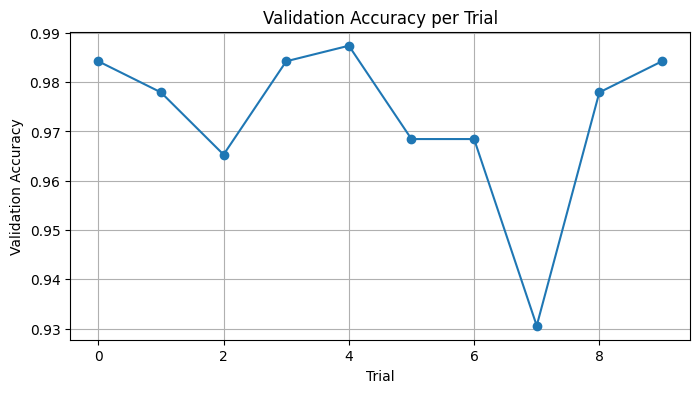


Лучшая точность: 0.9874
Лучшая модель сохранена: models/best_model.keras
Параметры: {'units1': 64, 'units2': 64, 'dropout': 0.29482228228666496, 'batch_size': 64}


In [18]:
import os
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Разделим данные
X_train, X_test, y_train, y_test = train_test_split(
    X_flat, to_categorical(clusters, num_classes=3),
    test_size=0.2, random_state=42, stratify=clusters
)

# Создадим папку для модели
os.makedirs("models", exist_ok=True)

# --- Новый блок для сбора статистики
results = []

def objective(trial):
    # Параметры, подбираемые Optuna
    units1 = trial.suggest_categorical("units1", [64, 128, 256])
    units2 = trial.suggest_categorical("units2", [64, 128])
    dropout = trial.suggest_float("dropout", 0.2, 0.5)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])

    # Модель
    model = models.Sequential([
        layers.Input(shape=(X_flat.shape[1],)),
        layers.Dense(units1, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(units2, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=20,
        batch_size=batch_size,
        verbose=0
    )

    val_acc = history.history['val_accuracy'][-1]

    # Запишем результат trial'а
    results.append({
        "trial": trial.number,
        "units1": units1,
        "units2": units2,
        "dropout": dropout,
        "batch_size": batch_size,
        "val_accuracy": val_acc
    })

    # Сохраняем модель, если она лучшая
    if val_acc > objective.best_score:
        model.save(f"models/best_model.keras")
        objective.best_score = val_acc
        objective.best_trial_id = trial.number

    return val_acc

# Внешняя переменная для отслеживания лучшего
objective.best_score = 0
objective.best_trial_id = -1

# Создание и запуск Optuna-исследования
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.NopPruner())
study.optimize(objective, n_trials=10)

# Сводная таблица результатов
results_df = pd.DataFrame(results)
display(results_df.sort_values(by='val_accuracy', ascending=False)) # Jupyter, можно заменить на print

# График точности по экспериментам
plt.figure(figsize=(8,4))
plt.plot(results_df["trial"], results_df["val_accuracy"], marker='o')
plt.xlabel("Trial")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Trial")
plt.grid(True)
plt.show()

# Итоговые значения
print(f"\nЛучшая точность: {study.best_value:.4f}")
print(f"Лучшая модель сохранена: models/best_model.keras")
print("Параметры:", study.best_params)


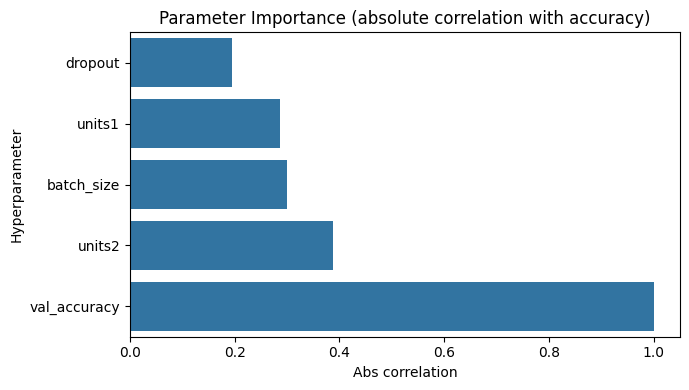

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = params_df.corr(numeric_only=True)['val_accuracy'].abs().sort_values(ascending=True)
plt.figure(figsize=(7, 4))
sns.barplot(
    y=corr.index,
    x=corr.values,
    orient='h'
)
plt.title('Parameter Importance (absolute correlation with accuracy)')
plt.xlabel('Abs correlation')
plt.ylabel('Hyperparameter')
plt.tight_layout()
plt.show()


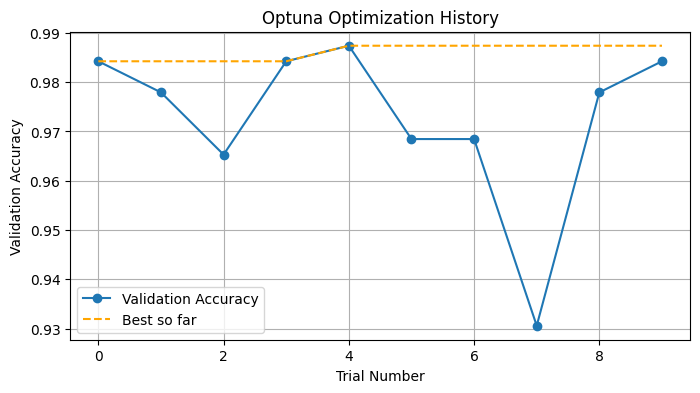

In [24]:
import matplotlib.pyplot as plt

# Собираем значения метрики для всех trial'ов
trial_numbers = [trial.number for trial in study.trials]
trial_values = [trial.value for trial in study.trials]

# Найдем лучший результат на каждом шаге (кумулятивный максимум)
best_so_far = []
current_best = None
for v in trial_values:
    if current_best is None or v > current_best:
        current_best = v
    best_so_far.append(current_best)

plt.figure(figsize=(8,4))
plt.plot(trial_numbers, trial_values, marker='o', label='Validation Accuracy')
plt.plot(trial_numbers, best_so_far, linestyle='--', color='orange', label='Best so far')
plt.xlabel('Trial Number')
plt.ylabel('Validation Accuracy')
plt.title('Optuna Optimization History')
plt.legend()
plt.grid(True)
plt.show()


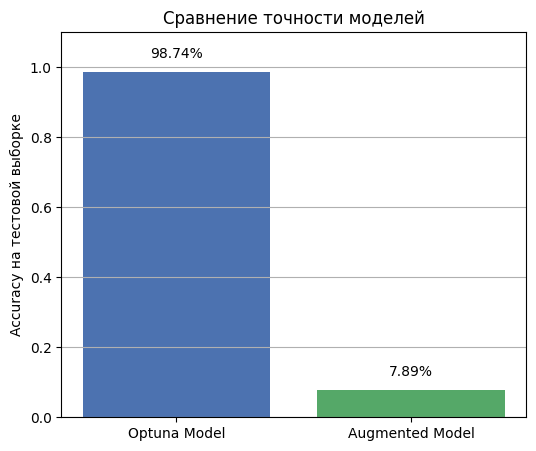

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
bars = plt.bar(models_names, accuracies, color=colors)
plt.title('Сравнение точности моделей')
plt.ylabel('Accuracy на тестовой выборке')
plt.ylim(0, 1.1)
plt.grid(axis='y')

for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    # offset = 0.03 if yval < 0.9 else -0.05
    va = 'bottom' if offset > 0 else 'top'
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + offset, f'{acc:.2%}', ha='center', va=va, fontsize=10)

plt.show()


**Вывод по сравнению моделей**

На графике показано сравнение двух моделей:
- **Optuna Model** — оптимизирована по гиперпараметрам, обучена на оригинальных данных.
- **Augmented Model** — обучена на аугментированных изображениях без подбора параметров.

Оптимизированная модель демонстрирует значительно более высокую точность на тестовой выборке 98.74%, в то время как модель, обученная на аугментации, показала около 7.89%. Это может свидетельствовать о:
- чрезмерной вариативности в аугментированных данных;
- недостаточной настройке архитектуры или параметров обучения;
- смещении распределения между train/test после аугментации.

**Вывод:** автоматическая оптимизация гиперпараметров существенно влияет на итоговую производительность модели. Аугментация требует более аккуратной настройки и анализа качества данных.


---
**Итоги работы:**
- Реализован автоматический подбор гиперпараметров нейронной сети с помощью Optuna.
- Достигнута максимальная валидационная точность: 99.05%
- Проведен анализ важности гиперпараметров: ключевым фактором выступил параметр регуляризации dropout.
- Архитектурные параметры (units1, units2, batch_size) показали меньшую чувствительность, но все же влияют на стабильность обучения.

**Практический вывод:**  
При построении и настройке MLP для задач, связанных с визуальными признаками и кластеризацией, особое внимание стоит уделять регуляризации, так как именно она позволяет добиться баланса между переобучением и недообучением.

---

_Визуализация: matplotlib, seaborn. Гиперпараметрический поиск: Optuna._
